### Text Generation from image
###### By Kruti Thukral (012586041)
###### Reference paper
Show and Tell: A Neural Image Caption Generator
Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan; The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015, pp. 3156-3164

Reference code snippet 
https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

As per the paper, a simple encoder-decoder architecture composed of a CNN and RNN can be used to generate text from an image. 


In [0]:
# Use unzip utility to unzip the flickr8k dataset. Run only once and is required when data is available in zipped format
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/image_captioning/Flickr8k_Dataset.zip", 'r')
# specify extraction path
zip_ref.extractall("/content/drive/My Drive/image_captioning/final1")
zip_ref.close()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# import required libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from google.colab import drive
# Remount google drive to access the flickr8k 





Using TensorFlow backend.


Mounted at /content/drive/


In [0]:
# remount to access extracted folder. Not required if data was available in unzipped format
drive.mount('/content/drive/', force_remount=True)

In [0]:
# utility to load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

root_dataset = "/content/drive/My Drive/image_captioning/"
root_flickr_text = "/content/drive/My Drive/image_captioning/Flickr8k_text/"
root_flickr_image = "/content/drive/My Drive/image_captioning/final1/Flicker8k_Dataset/"
filename = root_flickr_text + "/Flickr8k.token.txt"

# load captions for images
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
# Below path contains all the images
images = root_flickr_image
#!ls "/content/drive/My Drive/image_captioning/Flickr8k_Dataset/"
print(images)
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
print(len(img))

/content/drive/My Drive/image_captioning/final1/Flicker8k_Dataset/
8091


In [0]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [0]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, root_dataset + 'descriptions.txt')

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = root_flickr_text + 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = root_flickr_text + 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = root_flickr_text + 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(root_dataset + 'descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 8s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
print(len(train_img))
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

6000
Time taken in seconds = 2041.8512117862701


In [0]:

# Save the bottleneck train features to disk
root_flickr_pickle = root_dataset + "pickle/"
print(encoding_train)
with open(root_flickr_pickle + "encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

{'1000268201_693b08cb0e.jpg': array([0.12277619, 0.33294883, 0.7527169 , ..., 0.21939683, 0.30216384,
       0.40283245], dtype=float32), '1001773457_577c3a7d70.jpg': array([0.7366835 , 0.5911318 , 0.18194208, ..., 0.16030267, 0.34144694,
       0.9083161 ], dtype=float32), '1002674143_1b742ab4b8.jpg': array([0.37351888, 0.24596629, 0.96353096, ..., 1.1459363 , 0.2654016 ,
       0.01983147], dtype=float32), '1003163366_44323f5815.jpg': array([0.48603082, 0.29218277, 0.3143686 , ..., 0.98254836, 0.28108075,
       0.22330058], dtype=float32), '1007129816_e794419615.jpg': array([0.21595344, 0.15582047, 0.2947711 , ..., 0.40565026, 0.16532044,
       0.37416908], dtype=float32), '1007320043_627395c3d8.jpg': array([0.17231041, 0.49808356, 0.2157698 , ..., 0.09676236, 1.2298493 ,
       0.5421418 ], dtype=float32), '1009434119_febe49276a.jpg': array([0.5346086 , 1.3676211 , 0.7804355 , ..., 0.39463827, 0.8877233 ,
       1.0728823 ], dtype=float32), '1012212859_01547e3f17.jpg': array([0.24

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 333.0010995864868


In [0]:
# Save the bottleneck test features to disk
with open(root_flickr_pickle + "encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [0]:
train_features = load(open(root_flickr_pickle + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
# Load Glove vectors

glove_dir = root_dataset
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
#ran until here
root_model_weights = root_dataset + "model_weights/"
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(root_model_weights + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1021s 510ms/step - loss: 3.9153
Epoch 1/1
2000/2000 [==============================] - 1025s 512ms/step - loss: 3.3911
Epoch 1/1
2000/2000 [==============================] - 1033s 516ms/step - loss: 3.1864
Epoch 1/1
2000/2000 [==============================] - 1027s 513ms/step - loss: 3.0574
Epoch 1/1
2000/2000 [==============================] - 1025s 512ms/step - loss: 2.9622
Epoch 1/1
2000/2000 [==============================] - 1022s 511ms/step - loss: 2.8906
Epoch 1/1
2000/2000 [==============================] - 1017s 508ms/step - loss: 2.8346
Epoch 1/1
2000/2000 [==============================] - 1044s 522ms/step - loss: 2.7889
Epoch 1/1
2000/2000 [==============================] - 1039s 519ms/step - loss: 2.7492
Epoch 1/1
2000/2000 [==============================] - 1037s 519ms/step - loss: 2.7157


In [0]:
model.save_weights(root_model_weights + 'model_10.h5')

In [0]:
model.load_weights(root_model_weights + 'model_10.h5')

In [0]:
images = root_flickr_image

In [0]:
with open(root_flickr_pickle + "encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
# utility to predict caption using greedy search
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

The image vector for test images is available in encoding_test and can be accessed using an index. Lets check the predicted captions for the test images. 

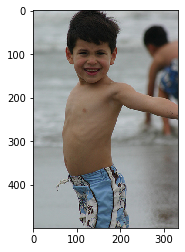

Greedy: boy in swim trunks is jumping into the water


In [0]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

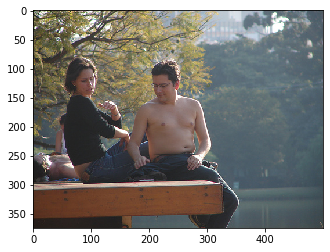

Greedy: man in black shirt and jeans is sitting on bench next to the door


In [0]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

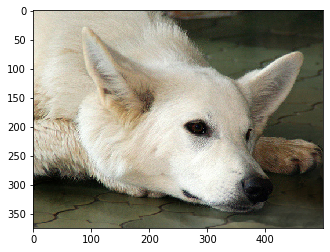

Greedy: man in black shirt and black shorts is sitting on the edge of the water


In [0]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

3


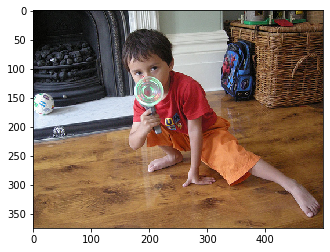

Greedy: man in black shirt is sitting on the edge of the fountain


In [0]:
print(z)
z+=1
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [0]:
print(encoding_test.keys())

dict_keys(['1056338697_4f7d7ce270.jpg', '106490881_5a2dd9b7bd.jpg', '1082379191_ec1e53f996.jpg', '1084040636_97d9633581.jpg', '1096395242_fc69f0ae5a.jpg', '1107246521_d16a476380.jpg', '1119015538_e8e796281e.jpg', '1122944218_8eb3607403.jpg', '1131800850_89c7ffd477.jpg', '1131932671_c8d17751b3.jpg', '113678030_87a6a6e42e.jpg', '114051287_dd85625a04.jpg', '115684808_cb01227802.jpg', '1167669558_87a8a467d6.jpg', '1174525839_7c1e6cfa86.jpg', '1174629344_a2e1a2bdbf.jpg', '1220401002_3f44b1f3f7.jpg', '1224851143_33bcdd299c.jpg', '1237985362_dbafc59280.jpg', '1248940539_46d33ed487.jpg', '1258913059_07c613f7ff.jpg', '1262583859_653f1469a9.jpg', '1267711451_e2a754b4f8.jpg', '127488876_f2d2a89588.jpg', '127490019_7c5c08cb11.jpg', '1282392036_5a0328eb86.jpg', '1287073593_f3d2a62455.jpg', '1287475186_2dee85f1a5.jpg', '1298295313_db1f4c6522.jpg', '1311388430_4ab0cd1a1f.jpg', '1317292658_ba29330a0b.jpg', '1322323208_c7ecb742c6.jpg', '132489044_3be606baf7.jpg', '1329832826_432538d331.jpg', '133272209

4


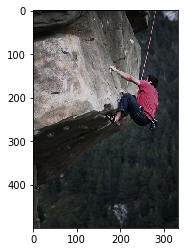

Greedy: man in red shirt climbs rock wall


In [0]:
print(z)
z = 999
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

999


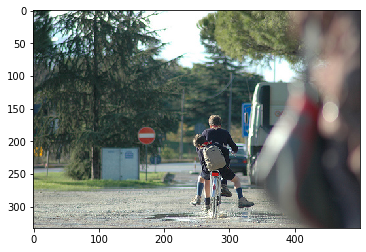

Greedy: man in blue hat and hat is riding bicycle down the sidewalk


In [0]:
print(z)
z = 500
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

500


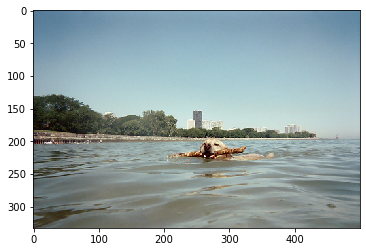

Greedy: dog is running through the water


In [0]:
print(z)
z = 400
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

Not bad predictions ! But we see that some predictions are incorrect. Lets train the model further for 10 epochs to see whether there are improvements in predictions.

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(root_model_weights + 'model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1038s 519ms/step - loss: 2.6865
Epoch 1/1
2000/2000 [==============================] - 1041s 520ms/step - loss: 2.6605
Epoch 1/1
2000/2000 [==============================] - 1035s 518ms/step - loss: 2.6368
Epoch 1/1
2000/2000 [==============================] - 1040s 520ms/step - loss: 2.6163
Epoch 1/1
2000/2000 [==============================] - 1037s 518ms/step - loss: 2.6006
Epoch 1/1
2000/2000 [==============================] - 1036s 518ms/step - loss: 2.5857
Epoch 1/1
2000/2000 [==============================] - 1039s 520ms/step - loss: 2.5683
Epoch 1/1
2000/2000 [==============================] - 1034s 517ms/step - loss: 2.5542
Epoch 1/1
2000/2000 [==============================] - 1033s 516ms/step - loss: 2.5438
Epoch 1/1
2000/2000 [==============================] - 1038s 519ms/step - loss: 2.5345


In [0]:
model.save_weights(root_model_weights + 'model_20.h5')

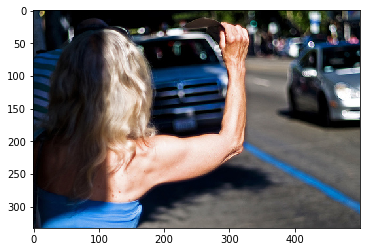

Greedy: woman in black shirt and beads cross


In [0]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

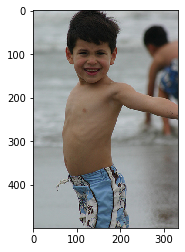

Greedy: young boy in swim trunks is jumping into the water


In [0]:
z += 1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

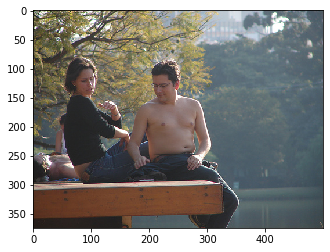

Greedy: man in black shirt and jeans is standing on the ground near the water


In [0]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

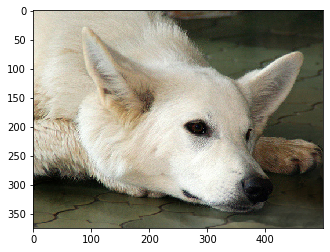

Greedy: the dog is walking on the pathway


In [0]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

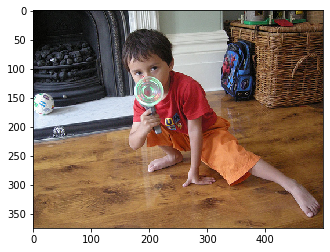

Greedy: man in black shirt is sitting on chair next to computer computer


In [0]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

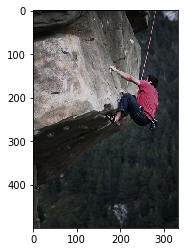

Greedy: man in red shirt is climbing rock wall


In [0]:
z = 999
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

999


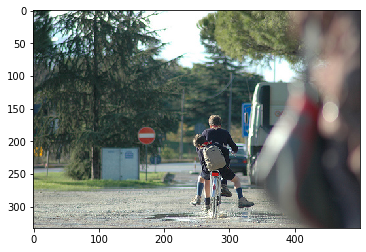

Greedy: man in red shirt and backpack biking down the street


In [0]:
print(z)
z = 500
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

500


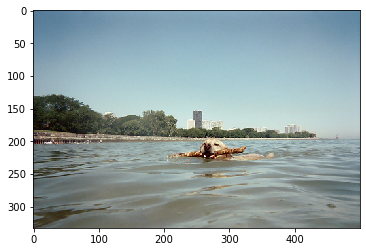

Greedy: dog is running through the water


In [0]:
print(z)
z = 400
pic = list(encoding_test.keys())[z]

image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

We see that there is slight improvement in model prediction on further training the model. We can continue this process until we reach the optimal weights for the trainable parameters.

In [0]:
model.optimizer.lr = 0.0001
epochs = 30
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
 947/1000 [===========================>..] - ETA: 43s - loss: 2.4196

In [0]:
model.save_weights(root_model_weights + 'model_30.h5')

In [0]:
# add code to generate captions depending on index
z = [0,1,2,3,4,999,500,400, 344, 200, 100, 56, 90, 466, 499, 677, 899, 15]
prediction = []
for i in z:
  item = {}
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,2048))
  item['x'] = images+pic
  item['index'] = i
  item['predicted_caption'] = greedySearch(image)
  prediction.append(item)
  


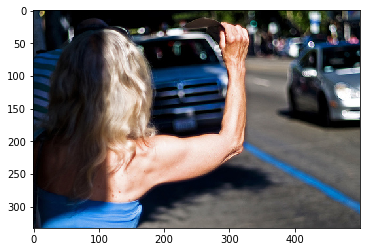

Index:0 Greedy:woman in black and white with black and white striped shirt is standing by the bus


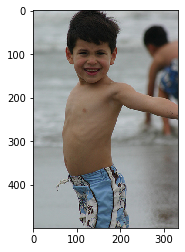

Index:1 Greedy:young boy in swim trunks is jumping into the water


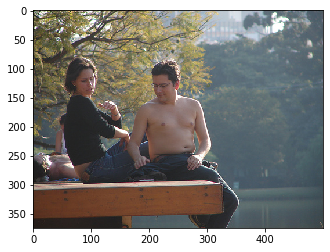

Index:2 Greedy:two men are sitting on bench outside


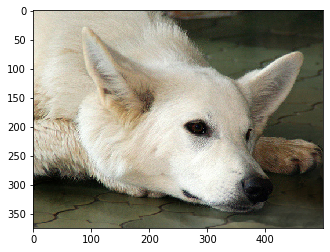

Index:3 Greedy:man in black shirt and jeans is sitting on the ground next to his cat


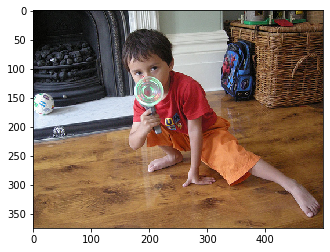

Index:4 Greedy:the little boy is sitting on the bed with the arm of the baby in the hospital


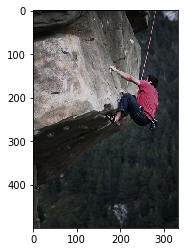

Index:999 Greedy:man in red shirt is scaling sheer cliff


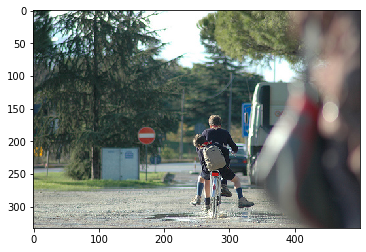

Index:500 Greedy:man in red jacket and backpack walking down street


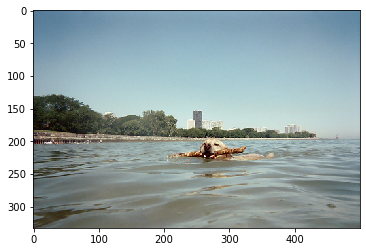

Index:400 Greedy:dog swimming through water


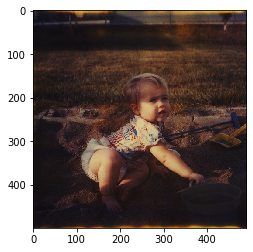

Index:344 Greedy:baby in overalls overalls tank top is sitting on the grass


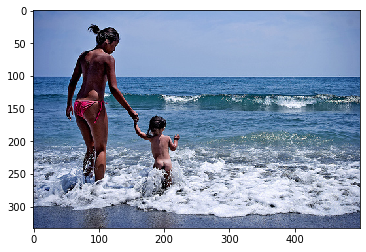

Index:200 Greedy:the boy is walking along the beach


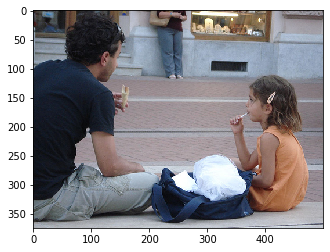

Index:100 Greedy:two women in formal wear are standing on the floor next to fence


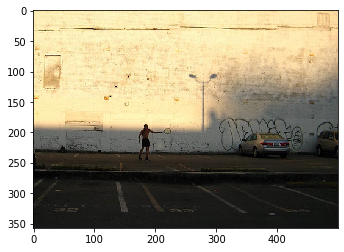

Index:56 Greedy:man in red shirt and jeans is standing on the street


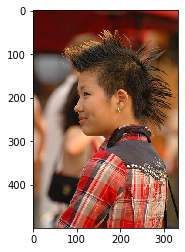

Index:90 Greedy:woman in black and white dress and black shirt is smiling


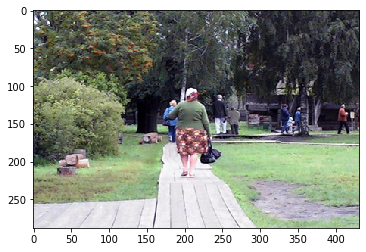

Index:466 Greedy:two women are sitting on the edge of wooden walkway


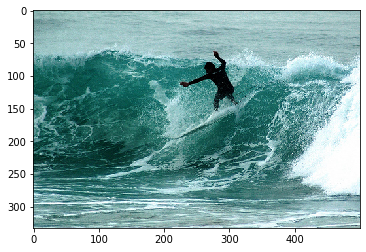

Index:499 Greedy:man in yellow kayak is paddling through the water


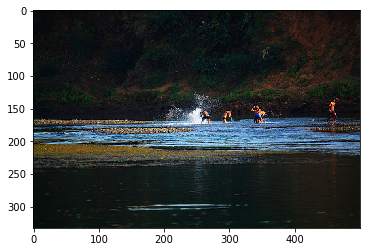

Index:677 Greedy:man in black swimsuit is jumping off dock into the water


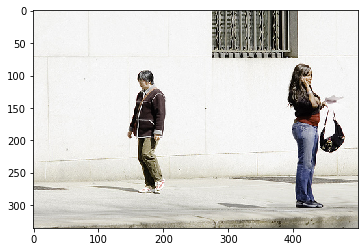

Index:899 Greedy:woman in black and white shirt and jean shorts walks down the street


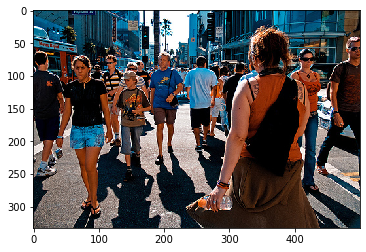

Index:15 Greedy:two women in heels walk down city street


In [0]:
for dic in prediction:
    x=plt.imread(dic['x'])
    plt.imshow(x)
    plt.show()
    print("Index:" + str(dic['index']) + " Greedy:" + dic['predicted_caption'])